### Pizzeria's Data

Наши разработчики создали новую версию бэкенда и хотят её протестировать. Новый бэкенд решает те же задачи, что и старый, поэтому улучшений во время эксперимента мы не ожидаем. Задача эксперимента — проверить, не возникнет ли проблем у пользователей, если мы заменим старую версию на новую. Например, если мы перейдём от монолитного ядра к микросервисной архитектуре. 

Одна из основных метрик бэкенда — время обработки запроса. Никто не любит, когда страницы сайта долго загружаются. Если страницы будут долго открываться, то часть пользователей перестанет заказывать пиццу на нашем сайте. 

В этом эксперименте мы будем оценивать изменение среднего времени обработки запросов. Если время обработки запроса значимо увеличится, то переход на новый бэкенд может привести к снижению выручки из-за ухода части пользователей.

Нужно разобраться, как подготовиться к запуску эксперимента и запустить A/B тест.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
# import datetime as dt
from datetime import datetime
from scipy import stats
import ipywidgets as widgets

titlesize = 10       # размер шрифта заголовков
labelsize = 10       # размер шрифта меток осей
legendsize = 10      # размер шрифта легенды
xticksize = 10       # размер шрифта меток на оси X
yticksize = xticksize # размер шрифта меток на оси Y (такой же, как у X)

# Настройки легенды:
plt.rcParams['legend.markerscale'] = 1.5     # масштаб маркеров в легенде относительно исходных
plt.rcParams['legend.handletextpad'] = 0.5   # расстояние между маркером и текстом в легенде
plt.rcParams['legend.labelspacing'] = 0.4    # вертикальный отступ между элементами легенды
plt.rcParams['legend.borderpad'] = 0.5       # отступ рамки легенды от содержимого

# Общие настройки шрифта:
plt.rcParams['font.size'] = 12               # базовый размер шрифта
plt.rcParams['font.serif'] = 'Times New Roman' # шрифт с засечками (по умолчанию)

# Настройки осей и заголовков:
plt.rcParams['axes.labelsize'] = labelsize    # размер меток осей (берётся из labelsize)
plt.rcParams['axes.titlesize'] = titlesize    # размер заголовков графиков (берётся из titlesize)

# Размер фигуры по умолчанию:
plt.rcParams['figure.figsize'] = (5, 3)       # ширина и высота графика в дюймах

# Настройки меток на осях:
plt.rc('xtick', labelsize=xticksize)          # размер меток на оси X
plt.rc('ytick', labelsize=yticksize)          # размер меток на оси Y
plt.rc('legend', fontsize=legendsize)         # размер шрифта в легенде

In [1]:
URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

In [ ]:
web_logs = read_database('2022-04-01T12_df_web_logs.csv')
web_logs['date'] = pd.to_datetime(web_logs['date'])
web_logs.head(3)

,user_id,page,date,load_time
0,f25239,m,2022-02-03 23:45:37,80.8
1,06d6df,m,2022-02-03 23:49:56,70.5
2,06d6df,m,2022-02-03 23:51:16,89.7


Web-logs — таблица с логами посещения сайта.

1. user_id — идентификатор пользователя;
2. page — какая страница сайта была открыта. Типы страниц:
    + m — страница с меню;
    + b  — страница с корзиной и подтверждением заказа;
    + p — страница с оплатой заказа;
3. date — дата открытия страницы;
4. load_time — время загрузки страницы в миллисекундах.

**Предполагается, что данные независимы**

2022-02-03 23:45:37
2022-04-01 11:59:57
(1964507, 4)


<Axes: >

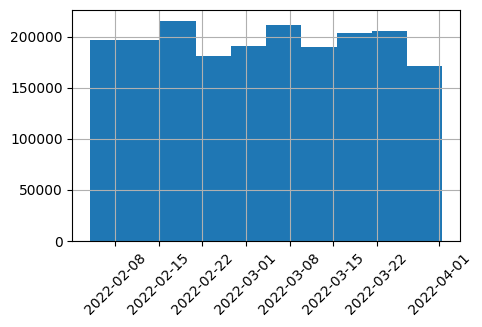

In [6]:
print(web_logs['date'].min())
print(web_logs['date'].max())
print(web_logs.shape)
web_logs['date'].hist(xrot=45)

Предположим, что мы хотим проводить тест в течение одной недели.

Для этого на историческом промежутке выберем интервал длинной в одну неделю и проведем все расчеты 
для данного промежутка времени. Отметим, что сегодня 1 апреля, 
поэтому мы взяли неделю непосредственно перед запуском эксперимента. 

Данный подход служит неплохой эвристикой.

In [8]:
web_logs_hist = web_logs[(web_logs['date'] >= datetime(2022, 3, 22)) & (web_logs['date'] < datetime(2022, 3, 29))]
web_logs_hist.shape

(247163, 4)

Предположим, что 1% для нас не является существенным изменением. 
То есть нас устроит любое изменение в пределах одного процента. 

Таким образом, если эффект будет равен одному проценту, мы хотим быть способны обнаружить его с большой вероятностью.

Зафиксируем параметры эксперимента и посчитаем необходимые статистики.

In [9]:
alpha = 0.05
beta = 0.2
eff = 1.01

mean = web_logs_hist['load_time'].mean()
std = web_logs_hist['load_time'].std()

print(f'Mean = {mean}, std = {std}')

Mean = 74.09834562616572, std = 111.56972405581008


Оценим размер выборки в одной группе (контрольной или экспериментальной)

In [11]:
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1-alpha/2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1-beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_sample_size_arb(mu, std, eff=1.01, alpha=0.05, beta=0.2):
    epsilon = (eff - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

def check_ttest(a, b, alpha=0.05):
    """Тест Стьюдента. Возвращает 1, если отличия значимы."""
    _, pvalue = stats.ttest_ind(a, b)
    return int(pvalue < alpha)

In [ ]:
sample_size = get_sample_size_abs(mean / 100, std, alpha=alpha, beta=beta) # mean / 100 - 1% процент от среднего - т.е. фактическое увеличение на 1 процент в абсолютном значении
print(f'sample_size = {sample_size}')

sample_size = get_sample_size_arb(mean, std, eff=eff, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 355889
sample_size = 355889


Для проведения эксперимента нам требуется 700 000 наблюдений в течение недели.
А всего у нас 247000 наблюдений за неделю до эксперимента.

Давайте попробуем решить обратную задачу. А какой эффект мы бы смогли обнаружить, 
проведи мы эксперимент на данной неделе, разбив всех пользователей на две группы?

In [14]:
def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1-alpha/2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1-beta, loc=0, scale=1)
    disp_sum_sqrt = (2*(std**2))**0.5
    mde = ((t_alpha + t_beta) * disp_sum_sqrt)/np.sqrt(sample_size)
    return mde

In [17]:
n = web_logs_hist.shape[0] // 2
print(f"Максимально доступный размер группы: {n}")
mde = get_minimal_determinable_effect(std, n, alpha=alpha, beta=beta)
print(f'mde = {np.round(mde, 3)}')
print(f'mde = {np.round(mde / mean * 100, 3)}%')

Максимально доступный размер группы: 123581
mde = 1.257
mde = 1.697%


Хотим 1%, а можем 1.7%. В будущем мы научимся увеличивать чувствительность тестов с помощью различных техник, 
а сейчас давайте предположим, что нас устроит чувствительность 3%. 
То есть мы считаем, что эффект менее 3% для нас незначителен.

Давайте оценим, сколько загрузок страниц нам потребуется для оценки эксперимента.

In [18]:
alpha = 0.05
beta = 0.2
eff = 1.03

mean = web_logs_hist['load_time'].mean()
std = web_logs_hist['load_time'].std()

sample_size = get_sample_size_arb(mean, std, eff=eff, alpha=alpha, beta=beta)
print(f'sample_size = {sample_size}')

sample_size = 39544


Таким образом, в каждую группу требуется выделить 40000 событий, связанных с загрузкой страницы, чтобы мы были способны отловить эффект 3% на уровне значимости 0.05 и мощностью 0.8.

Но эксперимент мы будем проводить на клиентах, поэтому давайте посчитаем, сколько клиентов требуется выделить в каждую группу. Для этого посчитаем, сколько в среднем каждый клиент делает сессий в течение недели.

In [21]:
ratio = web_logs_hist.groupby(['user_id'])['load_time'].count().mean()

print(ratio)

ratio = web_logs_hist.shape[0] / web_logs_hist['user_id'].nunique()
print(ratio)

7.015298592188919
7.015298592188919


In [22]:
n_users = int(sample_size / ratio) + 1
print(f'n_users = {n_users}')

n_users = 5637


Таким образом, основываясь на исторических данных, в каждую группу требуется выделить 6000 пользователей, 
которые сгенерируют достаточный трафик, чтобы мы были способны отловить эффект 3% на уровне значимости 0.05 и мощностью 0.8.


### Оценка необходимого размера групп по данным о покупках за неделю с 21 по 28 февраля.

In [ ]:
# Допустим, мы хотим провести эксперимент, в который попадают клиенты, совершившие покупку во время эксперимента.
# Метрика — средняя выручка с пользователя за время эксперимента;
# Продолжительность — одна неделя;
# Уровень значимости — 0.05;
# Допустимая вероятность ошибки II рода — 0.1;
# Ожидаемый эффект — 20 рублей.
# Оценм необходимый размер групп по данным о покупках за неделю с 21 по 28 февраля.


URL_BASE = 'https://raw.githubusercontent.com/ab-courses/simulator-ab-datasets/main/2022-04-01/'

epsilon = 20
alpha = 0.05
beta = 0.1

def read_database(file_name):
    return pd.read_csv(os.path.join(URL_BASE, file_name))

df_sales = read_database('2022-04-01T12_df_sales.csv')
df_sales['date'] = pd.to_datetime(df_sales['date'])

begin_date = datetime(2022, 2, 21)
end_date = datetime(2022, 2, 28)
df_sales.head()

,sale_id,date,count_pizza,count_drink,price,user_id
0,1000001,2022-02-04 10:00:24,1,0,720,1c1543
1,1000002,2022-02-04 10:02:28,1,1,930,a9a6e8
2,1000003,2022-02-04 10:02:35,3,1,1980,23420a
3,1000004,2022-02-04 10:03:06,1,1,750,3e8ed5
4,1000005,2022-02-04 10:03:23,1,1,870,cbc468


In [80]:
def get_sample_size_abs(epsilon, std, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1-alpha/2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1-beta, loc=0, scale=1)
    z_scores_sum_squared = (t_alpha + t_beta) ** 2
    sample_size = int(
        np.ceil(
            z_scores_sum_squared * (2 * std ** 2) / (epsilon ** 2)
        )
    )
    return sample_size

def get_sample_size_arb(mu, std, eff=1.01, alpha=0.05, beta=0.2):
    epsilon = (eff - 1) * mu

    return get_sample_size_abs(epsilon, std=std, alpha=alpha, beta=beta)

In [ ]:
df = df_sales[(df_sales['date']>=begin_date) & (df_sales['date'] < end_date)].groupby('user_id').agg(revenue_per_user = ('price', 'sum')).fillna(0).reset_index()
mean_revenue = df['revenue_per_user'].mean()
std_revenue = df['revenue_per_user'].std()
print(f"std: {std_revenue:.3f}, mean: {mean_revenue:.3f}")

sample_size = get_sample_size_abs(epsilon, std_revenue, alpha, beta)
print('Sample size: [метрик по средней выручке]', round(sample_size, -1))

std: 811.180, mean: 1234.687
Sample size: [метрик по средней выручке] 34570


(24840,)

In [ ]:
df = df_sales[(df_sales['date']>=begin_date) & (df_sales['date'] < end_date)].groupby('user_id').agg(order_per_user = ('sale_id', 'count')).fillna(0).reset_index()
mean_orders = df['order_per_user'].mean()
std_orders = df['order_per_user'].std()
print(f"std: {std_orders:.3f}, mean: {mean_orders:.3f}")
n_users = np.ceil(sample_size/mean_orders)
print(f"Количество пользователей в одной группе с учетом среднего количества заказов: {n_users}")

std: 0.148, mean: 1.020
Количество пользователей в одной группе с учетом среднего количества заказов: 33880.0


### Минимальный эффект который можно отловить

In [ ]:
# Task 2.
# В прошлом задании получилось, что необходимый размер групп больше имеющихся данных за одну неделю. 
# Какой минимальный эффект мы можем отловить с теми же вероятностями ошибок на данных
# с 21 по 28 февраля?

# Ответ округлите до целого значения.

def get_minimal_determinable_effect(std, sample_size, alpha=0.05, beta=0.2):
    t_alpha = stats.norm.ppf(1-alpha/2, loc=0, scale=1)
    t_beta = stats.norm.ppf(1-beta, loc=0, scale=1)
    disp_sum_sqrt = (2*(std**2))**0.5
    mde = ((t_alpha + t_beta) * disp_sum_sqrt)/np.sqrt(sample_size)
    return mde
sample_size = df.shape[0]  # по сути число уникальных пользователей сделавших заказ в этот период
# df_sales[(df_sales['date']>=begin_date) & (df_sales['date'] < end_date)].user_id.unique().shape[0] # то же самое
print(f"sample_size: {sample_size}")
mde = get_minimal_determinable_effect(std_revenue, sample_size//2, alpha, beta)
print(f"Миниальный эффект: {round(mde)}")


sample_size: 24840
Миниальный эффект: 33


### Метод estimate_sample_size класса ExperimentsService

In [ ]:

# Напишем метод estimate_sample_size класса ExperimentsService. 
# Размер эффекта задаётся в процентах;
# Для вычисления стандартного отклонения используем функцию np.std с параметрами по умолчанию.


import numpy as np
import pandas as pd
from pydantic import BaseModel
from scipy import stats


class Design(BaseModel):
    """Дата-класс с описание параметров эксперимента.
    
    statistical_test - тип статтеста. ['ttest']
    effect - размер эффекта в процентах
    alpha - уровень значимости
    beta - допустимая вероятность ошибки II рода
    """
    statistical_test: str
    effect: float
    alpha: float
    beta: float


class ExperimentsService:

    def estimate_sample_size(self, metrics, design):
        """Оцениваем необходимый размер выборки для проверки гипотезы о равенстве средних.
        
        Для метрик, у которых для одного пользователя одно значение просто вычислите размер групп по формуле.
        Для метрик, у которых для одного пользователя несколько значений (например, response_time),
            вычислите необходимый объём данных и разделите его на среднее количество значений на одного пользователя.
            Пример, если в таблице metrics 1000 наблюдений и 100 уникальных пользователей, и для эксперимента нужно
            302 наблюдения, то размер групп будет 31, тк в среднем на одного пользователя 10 наблюдений, то получится
            порядка 310 наблюдений в группе.

        :param metrics (pd.DataFrame): датафрейм со значениями метрик из MetricsService.
            columns=['user_id', 'metric']
        :param design (Design): объект с данными, описывающий параметры эксперимента
        :return (int): минимально необходимый размер групп (количество пользователей)
        """
        effect = design.effect
        alpha = design.alpha
        beta = design.beta
        std = np.std(metrics['metric'])
        mean = np.mean(metrics['metric'])
        epsilon = effect / 100 * mean
        coef = metrics['user_id'].nunique() / len(metrics)

        t_alpha = stats.norm.ppf(1 - alpha/2, loc=0, scale=1)
        t_beta = stats.norm.ppf(1 - beta, loc=0, scale=1)
        z_scores_sum_squared = (t_alpha + t_beta) ** 2
        sample_size = int(np.ceil(z_scores_sum_squared * (2*std ** 2)/(epsilon ** 2) * coef))
        # print(sample_size)
        return sample_size
    
if __name__ == '__main__':
    metrics = pd.DataFrame({
        'user_id': [str(i) for i in range(10)],
        'metric': [i for i in range(10)]
    })
    design = Design(
        statistical_test='ttest',
        alpha=0.05,
        beta=0.1,
        effect=3.
    )
    ideal_sample_size = 9513

    experiments_service = ExperimentsService()
    sample_size = experiments_service.estimate_sample_size(metrics, design)
    assert sample_size == ideal_sample_size, 'Неверно'
    print('simple test passed')


9513
simple test passed
